# Circuitos dinâmicos

Possibilita incluir controle clássico durante a computação quântica.

Pode ser útil para trocar profundidade por largura de circuitos quânticos.

## Teleportação de porta lógica quântica

![](https://drive.google.com/uc?export=view&id=1vslsiLdJpk0jWTuc4i-vIt-gGiM45zrN)

### Passo 1: Mapear o problema para circuitos e operadores

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit_aer
!pip install matplotlib
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 24.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr # para lógica clássica

In [ ]:
def get_dynamic_CNOT_circuit(num_qubit):
  """
  Suposições:
  (1) cadeia unidimensional de 1ºs vizinhos
  (2) qubit 0 = controle, último qubit = alvo
  (3) qubit 0 começa no estado +
  """
  num_ancilla = num_qubit - 2
  num_ancilla_pair = int(num_ancilla/2)
  qr = QuantumRegister(num_qubit)
  cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # para a X controlada por paridade
  cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # para a Z controlada por paridade
  cr3 = ClassicalRegister(2, name="cr3") # para medidas no controle e no target
  qc = QuantumCircuit(qr, cr1, cr2, cr3)

  qc.h(0); qc.barrier() # inicialização do controle
  qc.cx(0,1) # emaranha o controle e o 1º ancilla

  for j in range(num_ancilla_pair): # cria pares de Bell nos qubits auxiliares
    qc.h(2+2*j)
    qc.cx(2+2*j,2+2*j+1)

  for j in range(num_ancilla_pair+1):
    qc.cx(1+2*j, 1+2*j+1)
  for j in range(1, num_ancilla_pair+2):
    qc.h(2*j-1)

  # mede qubits auxiliares alternadamente e guarda paridade para a Z controlada
  for j in range(1, num_ancilla_pair+2):
    qc.measure(2*j-1, cr2[j-1])
    if j == 1:
      parity_control = expr.lift(cr2[j-1])
    else:
      parity_control = expr.bit_xor(cr2[j-1], parity_control)

  # mede qubits auxiliares alternadamente e guarda paridade para a X controlada
  for j in range(num_ancilla_pair):
    qc.measure(2*j+2, cr1[j])
    if j == 0:
      parity_target = expr.lift(cr1[j])
    else:
      parity_target = expr.bit_xor(cr1[j], parity_target)

  # aplica as operações condicinadas no resultado clássico
  with qc.if_test(parity_control):
    qc.z(0)
  with qc.if_test(parity_target):
    qc.x(-1) # aplica no último qubit

  # Final measurements on the control and target qubits
  qc.measure(0, cr3[0])
  qc.measure(-1, cr3[1])

  return qc

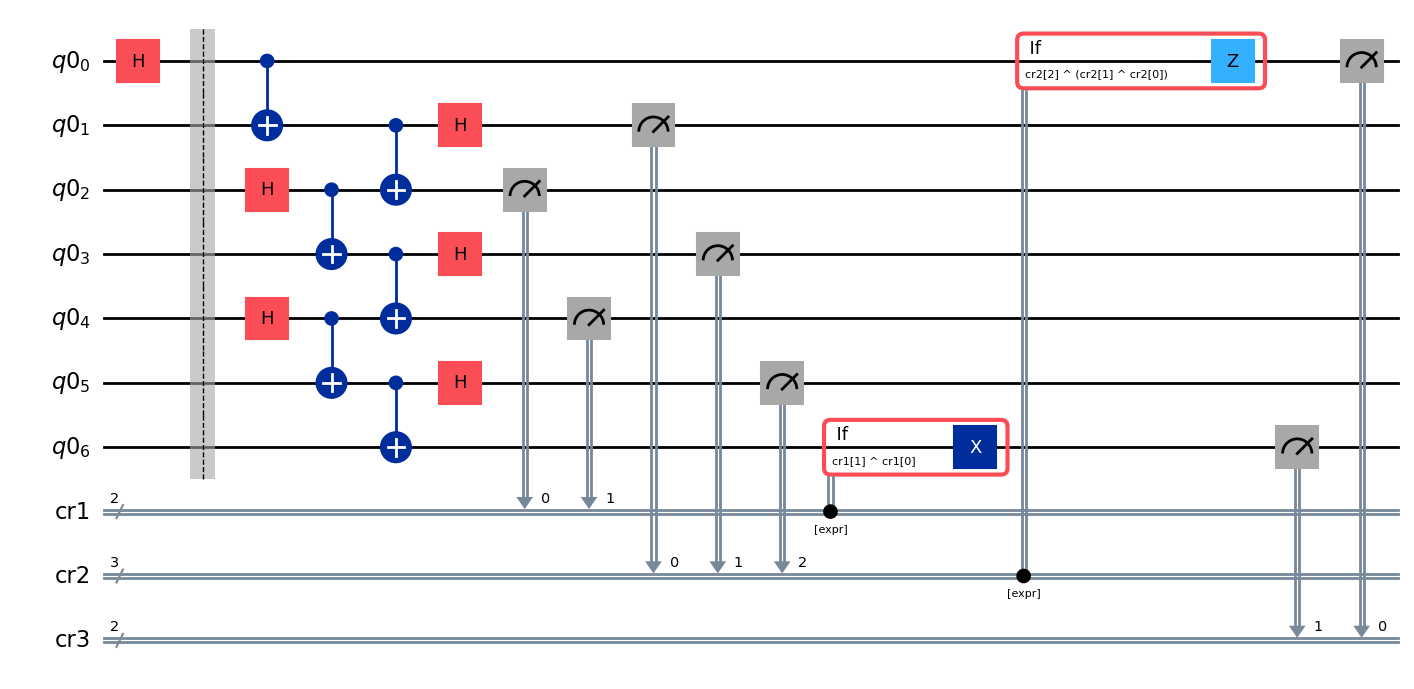

In [ ]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

In [ ]:
# cria uma lista de circuitos variando o nº de qubits

max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

### Passo 2: Otimizar os circuitos para execução

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="e8d1302bb6027e42bb64c2adface70102ccf7c0eebb5540af70ec91cf079aa513876e4c23d652ab18cb8a59b9fa12efbacde922564e7f2bb8463e1f7b1b2915d")
backend = service.backend(name="ibm_brisbane")

In [ ]:
# para resolver o problema de transpilação
from qiskit.circuit import IfElseOp
backend.target.add_instruction(IfElseOp, name="if_else")

In [ ]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_transpiled_list = pm.run(qc_list)

### Passo 3: Executar o circuito

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

csb28q2d3kwg008hbjsg


### Passo 4: Pós-processamento

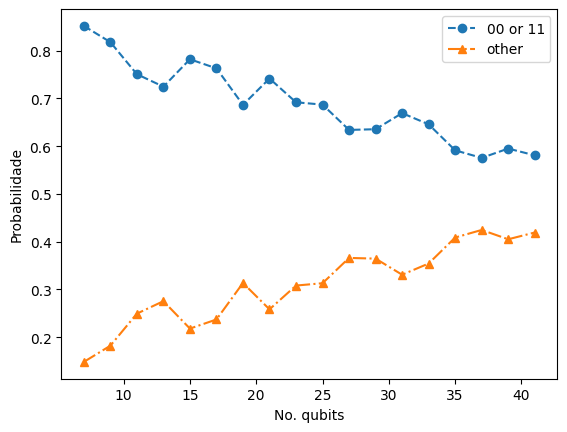

In [ ]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'csb28q2d3kwg008hbjsg'
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for j in range(0, len(qc_list)):
    data = result[j].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('No. qubits')
plt.ylabel('Probabilidade')
plt.legend()

## Referências

1. A. Javadi-Abhari et al., “Quantum computing with Qiskit.” arXiv, May 14, 2024. doi: 10.48550/arXiv.2405.08810.

1. Derek Wang, Coding with Qiskit 1.x, https://youtube.com/playlist?list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi&si=fVV8M_REENx6fcsa